# Radon transform - report
### Authors
- Marcin Szwarc 148192
- Helena Masłowska 148182

### This file contains:
- Radon transform
- filtering
- Invert Radon transform
- normalization

### The model of the tomograph used
- conical
### Programming language used
- python, jupyter


### All libraries we use

In [1]:
# Math libraries
import numpy as np
# Image support
import skimage as ski
import matplotlib.pyplot as plt
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity
from skimage.metrics import mean_squared_error as mse
# DICOM support
import pydicom
from pydicom.dataset import Dataset, FileDataset
import pydicom._storage_sopclass_uids
# For filtering
import cv2
# Jupyter widgets
from ipywidgets import interact, IntSlider, Text, Button, VBox
# To be aware of the environment
import datetime

## Simulation parameters
Set the simulation parameters and the input file name here.

In [2]:
scans = 180
detectors = 180
detectingAngle = 180
imageName = 'images/Shepp_logan.jpg'

def setParams(numScans, numDetectors, detectingArchAngle, inputFileName):
    global scans, detectors, detectingAngle, imageName
    scans = numScans
    detectors = numDetectors
    detectingAngle = detectingArchAngle
    imageName = inputFileName

interact(setParams,
    numScans=IntSlider(min=90, max=720, step=90, value=180, description='Scans'),
    numDetectors=IntSlider(min=90, max=720, step=90, value=180, description='Detectors'),
    detectingArchAngle=IntSlider(min=45, max=270, step=45, value=180, description='Det. angle'),
    inputFileName=Text(value='images/Shepp_logan.jpg', description='Input file'),
)

interactive(children=(IntSlider(value=180, description='Scans', max=720, min=90, step=90), IntSlider(value=180…

<function __main__.setParams(numScans, numDetectors, detectingArchAngle, inputFileName)>

## Input / output
### Image file
These routines do the I/O operations and make sure the data is properly scaled and/or projected.

In [3]:
def loadImage(filename):
    image = ski.io.imread(filename)
    image = image.astype(np.float64)
    if len(image.shape) == 3:
        image = ski.color.rgb2gray(image)
    image /= np.max(image)
    return image

def saveImage(image, filename):
    data = (image * 255).astype(np.uint8)
    ski.io.imsave(filename, data)

def showImage(image, title=None):
    if title is not None:
        plt.title(title)
    plt.imshow(image, cmap='gray')
    plt.show()

### Dicom file
Same for DICOM files.

In [4]:
# Use this file as a wireframe while constructing a new DICOM file
REFERENCE_DICOM = 'dicom/Kolo.dcm'
def loadDicom(filename):
    ds = pydicom.dcmread(filename)
    imageData = ds.pixel_array
    image = imageData / np.max(imageData)

    patName = ds.PatientName
    displayName = patName.given_name + " " + patName.family_name
    comment = ds.ImageComments
    acquisitionDate = ds.get('AcquisitionDate', None)

    metadata = (displayName, comment, acquisitionDate)
    return image, metadata

def saveDicom(filename, image, metadata):
    imageData = (image * 255).astype(np.uint8)

    ds = pydicom.dcmread(REFERENCE_DICOM)
    ds.PixelData = imageData.tobytes()
    ds.Rows, ds.Columns = imageData.shape

    patName = metadata[0].split(' ', maxsplit=1)
    if len(patName) == 1:
        patName = [patName[0], '' ]
    ds.PatientName = patName[1] + ' ' + patName[0]
    ds.ImageComments = metadata[1]
    ds.AcquisitionDate = metadata[2]
    ds.save_as(filename, write_like_original=False)


## Radon transform
Converts an image file to a sinogram. A circle which takes data is circumscribed around a rectangle. Rotates from the bottom of the image in the clockwise direction with the indicated number of scans by a certain angle, here by default 180 scans and 180 degrees.There are 180 detectors by default.
- image: 2D array (floats in range [0, 1])
- detectors: number of detectors (equally spaced on an arc)
- scans: number of samples to take (emitter positions equally spaced around the circle)
- detectingAngle: angle of the arc (in degrees) with detectors

Returns: sinogram, np.ndarray

In [5]:
def radonTransform(image, detectors = 180, scans = 180, detectingAngle = 180):
	center = np.array(image.shape) // 2     # Center of the emitter-detector system
	radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
	radonImage = np.zeros((scans, detectors), dtype=image.dtype)
	phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
	
	# Where to place the emitter in subsequent scans
	scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)

	detectorAngleGap = phi / (detectors - 1)
	for i, angle in enumerate(scanAngles):
		
		E = np.array([np.cos(angle), np.sin(angle)]) * radius + center
		for j in range(detectors):
			# Where to place the j-th detector
			detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
			D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

			# Make a line between the emitter and the detector
			# And ensure it is in bounds of the image
			y, x = ski.draw.line_nd(E, D)
			inBounds = (0 <= x) & (x < image.shape[1]) & (0 <= y) & (y < image.shape[0])
			line = (y[inBounds], x[inBounds])
			# Average the values of the image along the line
			radonImage[i, j] = np.average(image[line] if len(line[0]) > 0 else [0])
	return radonImage

## Sinogram filtering
Function to filter image with different filters. By default you can use numpy (better option) or opencv if you prefer to see what happens.
- image: image to filter, np.ndarray
- lib: library to use, you can switch between **numpy** (set as default) or **opencv**

Returns: filtered image, np.ndarray

In [6]:
def filtering(image, lib='numpy'):									# lib: 'numpy' or 'opencv'
	if (lib == 'opencv'):											# If opencv is used
		kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])	# Kernel shape: 3x3
		img = cv2.filter2D(image, -1, kernel)						# Filtering
		return img
	else:															# As a default, numpy is used
		kernel = np.zeros(21)										# Kernel shape: 21x1
		kernel[10] = 1
		for i in range(11, 21, 2):
			kernel[i] = -4/np.pi**2/(i-10)**2 
		kernel[:10] = kernel[11:][::-1]								# Mirror the kernel
		for iteration, i in enumerate(image):
			image[iteration] = np.convolve(i, kernel, mode='same')	# Filtering
		return image


## Inverse Radon transform
Does an inverse Radon transform using sinogram
- image: np.ndarray (floats in range [0, 1])
- shape: shape of an Radon image
- detectingAngle: angle of the arc (in degrees) with detectors

Returns: inverse Radon transform, np.ndarray

In [7]:
invRadonSteps = [] 							# invRadonSteps - list of step-by step images
def inverseRadonTransform(image, shape, detectingAngle = 180):
    global invRadonSteps
    scans = image.shape[0]
    detectors = image.shape[1]
    center = np.array(shape) // 2     		# Center of the emitter-detector system
    radius = np.sqrt(2) * max(center)       # Radius of the round frame (half-diagonal of the image)
    invRadonImage = np.zeros(shape, dtype=image.dtype)
    phi = np.deg2rad(detectingAngle)        # Span of the detectors arc
    invRadonSteps = []

    # Where to place the emitter in subsequent scans
    scanAngles = np.linspace(0, 2 * np.pi, scans, endpoint=False)
    detectorAngleGap = phi / (detectors - 1)
    for i, angle in enumerate(scanAngles):
        E = np.array([np.cos(angle), np.sin(angle)]) * radius + center

        for j in range(detectors):
            # Where to place the j-th detector
            detectorAngle = angle + np.pi - phi / 2 + j * detectorAngleGap
            D = np.array([np.cos(detectorAngle), np.sin(detectorAngle)]) * radius + center

            # Make a line between the emitter and the detector
            # And ensure it is in bounds of the image
            y, x = ski.draw.line_nd(E, D)
            inBounds = (0 <= x) & (x < shape[1]) & (0 <= y) & (y < shape[0])
            line = (y[inBounds], x[inBounds])

            # Average the values of the image along the line
            invRadonImage[line] += image[i, j]
        invRadonSteps.append(invRadonImage.copy())
    return invRadonImage

## Normalize post-transform image
Ensures that the result pixels are in range [0, 1]. All the negative values are replaced with zeros, whereas all that exceed the 99.9th percentile are replaced with ones. Everything in between is scaled linearly into the interval.

- image: image to be normalized, np.ndarray

Returns: normalized image, np.ndarray

In [8]:
def normalizePostTransform(image):
    image = np.maximum(image, 0)
    image = (image / np.quantile(image, 0.999)).astype(np.float64)
    image = np.minimum(image, 1)
    return image

# Save as dicom file
- file_name - string, where you save the file
- img - np.ndarray, your image
- patient_data - dict, add patient data to file


In [9]:
def convert_image_to_ubyte(img):
    return img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))

def save_as_dicom(file_name, img, patient_data):
    img_converted = convert_image_to_ubyte(img)
    # Populate required values for file meta information
    meta = Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = FileDataset(None, {}, preamble=b"\0" * 128)
    ds.file_meta = meta

    ds.is_little_endian = True
    ds.is_implicit_VR = False

    ds.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.SOPInstanceUID = meta.MediaStorageSOPInstanceUID
    ds.PatientName = patient_data["PatientName"]
    ds.PatientID = patient_data["PatientID"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.PatientBirthDate = patient_data["PatientBirthDate"]
    ds.Modality = "CT"
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.FrameOfReferenceUID = pydicom.uid.generate_uid()

    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.SamplesPerPixel = 1
    ds.HighBit = 7
    ds.ImagesInAcquisition = 1
    ds.InstanceNumber = 1

    ds.Rows, ds.Columns = img_converted.shape
    ds.ImageType = r"ORIGINAL\PRIMARY\AXIAL"
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    pydicom.dataset.validate_file_meta(ds.file_meta, enforce_standard=True)
    ds.PixelData = img_converted.tobytes()
    ds.save_as(file_name, write_like_original=False)

# Radon transform and inverse Radon transform with and without filtering using opencv and numpy convolution
Image -> Radon transform -> sinogram -> filtering -> Inverted Radon transform -> normalizing -> Image

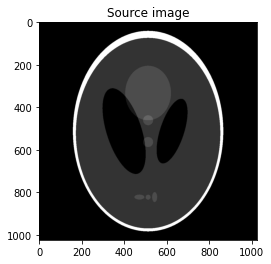

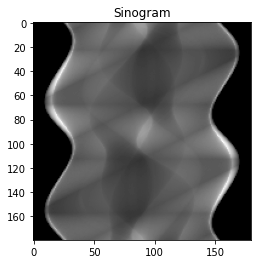

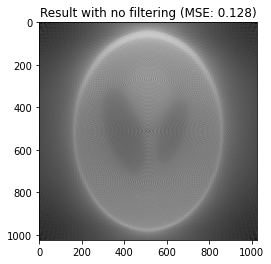

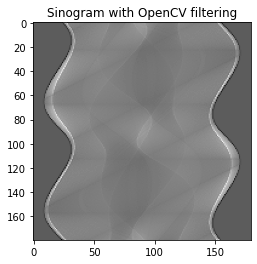

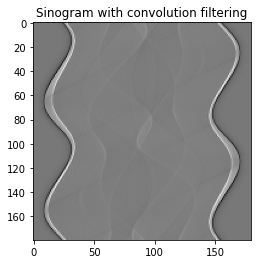

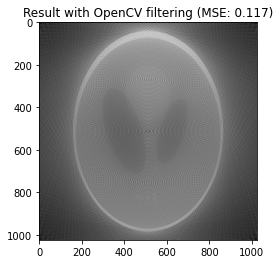

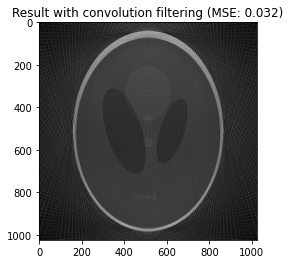

In [10]:
image = loadImage(imageName)
showImage(image, title='Source image')

radonImage = radonTransform(image, detectors, scans, detectingAngle)
showImage(radonImage, title='Sinogram')

invRadonTransform = inverseRadonTransform(radonImage, image.shape, detectingAngle)
invRadonTransform = normalizePostTransform(invRadonTransform)
imMse = mse(image, invRadonTransform)
showImage(invRadonTransform, title=f'Result with no filtering (MSE: {imMse:.3f})')

radonImageOpenCV = filtering(radonImage, 'opencv')
showImage(radonImageOpenCV, title='Sinogram with OpenCV filtering')

radonImageConv = filtering(radonImage, 'numpy')
showImage(radonImageConv, title='Sinogram with convolution filtering')

invRadonTransform = inverseRadonTransform(radonImageOpenCV, image.shape, detectingAngle)
invRadonTransform = normalizePostTransform(invRadonTransform)
imMse = mse(image, invRadonTransform)
showImage(invRadonTransform, title=f'Result with OpenCV filtering (MSE: {imMse:.3f})')

invRadonTransform = inverseRadonTransform(radonImageConv, image.shape, detectingAngle)
invRadonTransform = normalizePostTransform(invRadonTransform)
imMse = mse(image, invRadonTransform)
showImage(invRadonTransform, title=f'Result with convolution filtering (MSE: {imMse:.3f})')

### Slider
Rerun this cell if you changed the number of scans.

In [11]:
def showPartialImage(n):
    showImage(invRadonSteps[n-1])

interact(showPartialImage, n=IntSlider(min=1,max=len(invRadonSteps),step=1,value=10))

interactive(children=(IntSlider(value=10, description='n', max=180, min=1), Output()), _dom_classes=('widget-i…

<function __main__.showPartialImage(n)>

# Save DICOM file with given file name, patient name and image comments

In [12]:
outputFileName = 'out.dcm'
def saveInteractive(fileName, patientName, imageComments):
    global outputFileName
    today = datetime.date.today()
    saveDicom(fileName, invRadonTransform, (patientName, imageComments, today.strftime("%Y%m%d")))
    outputFileName = fileName

tb_fileName = Text(value=outputFileName, description='File name:')
tb_patientName = Text(value='Jan Kowalski', description='Patient name:')
tb_imageComments = Text(value='Everything ok', description='Comments:')

btn_save = Button(description='Save')
btn_save.on_click(lambda x: saveInteractive(tb_fileName.value, tb_patientName.value, tb_imageComments.value))

vb = VBox([tb_fileName, tb_patientName, tb_imageComments, btn_save])
display(vb)

# Import saved dicom file from previous step and show it

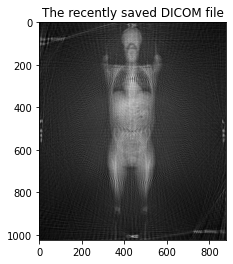

Patient's full name: 	Kowalski Jan
Image comments: 	Broken bone


In [13]:
def importDicomSavedFile():
	ds = pydicom.filereader.dcmread(outputFileName)
	showImage(ds.pixel_array, title='The recently saved DICOM file')
	print("Patient's full name: \t" + str(ds.PatientName))
	print("Image comments: \t" + ds.ImageComments)

importDicomSavedFile()

# Summary

### The result of the experiment checking the impact of individual parameters on the quality of the resulting image expressed by the MSE measure
The following measurements were performed on the Shepp-Logan image.

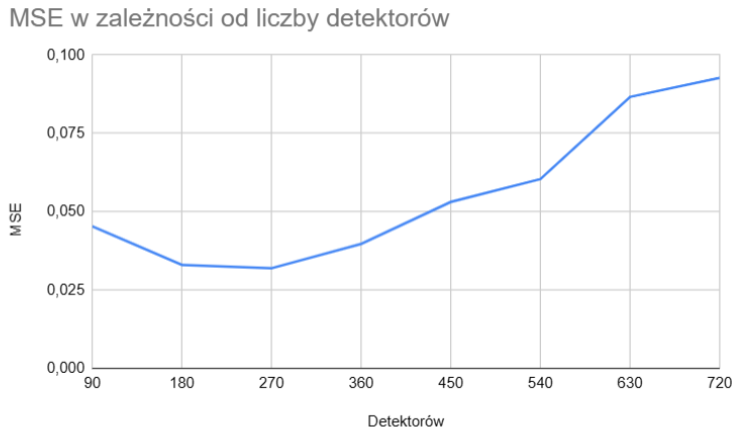

The more detectors, the brighter the image was observed. However, as the brightness increases, diagonal lines appear in the empty space of the image. Details were easiest to see for 270-360 detectors.

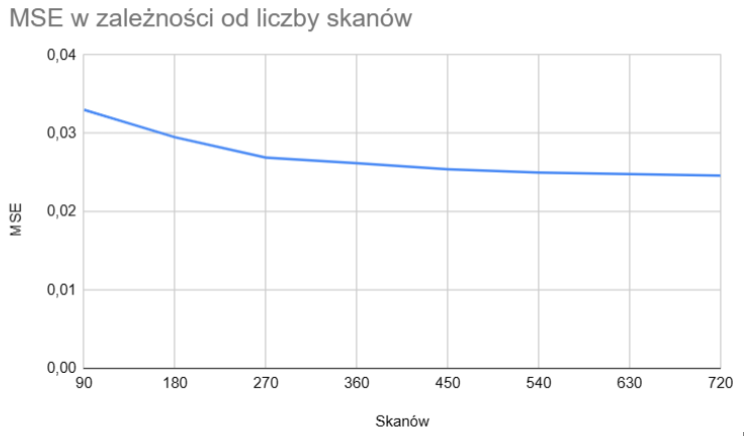

Increasing the number of scans allows for a more detailed image. This gain is most noticeable with a small number of scans.

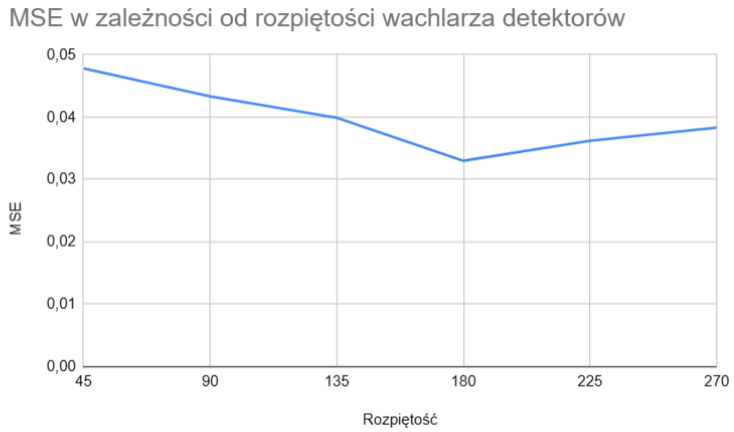

The small span of the arc on which the detectors are mounted narrows the area where the image will appear (and a bright rim appears on its edge). This effect was visible for spans up to and including 135 degrees (the larger the span, the larger the image fragment was observed at the output). Further magnification of the arc with detectors reduces the brightness of the resulting image. The effect for 180 degrees was subjectively the best.